In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from tensorflow.keras.datasets import mnist, fashion_mnist
from sklearn import metrics
from sklearn.metrics import roc_auc_score, plot_roc_curve
from tqdm.notebook import tqdm_notebook

import time

C:\Users\An-ck\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\An-ck\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\An-ck\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\An-ck\anaconda3\lib\site-packages\tensorboard\compat\tensorflow_stub\dtypes.

The data is loaded.

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# Normalize the input data to inverval [0, 1]
x_train = x_train.astype('float32') / 255
x_test  = x_test.astype('float32') / 255
# Flatten each image into a vecto'r
x_train = x_train.reshape(len(x_train), 784)
x_test  = x_test.reshape(len(x_test), 784)

In [3]:
def display10(imgs):
    n = 10  # How many digits we will display
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

Some hand-written digits from the dataset is shown.

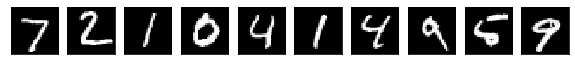

In [4]:
display10(x_test)

**First Case**: The number '4' is considered the normal case.

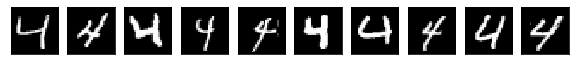

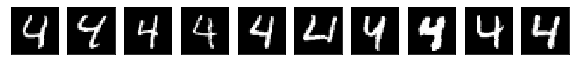

In [5]:
normal_train = x_train[np.where(y_train == 4)]
normal_test  = x_test[np.where(y_test == 4)]

display10(normal_train)
display10(normal_test)

A simple autoencoder structure is defined.

In [6]:
#Sigmoid and ReLU are appropriate activation functions when having nonnegative data.
model = keras.Sequential([
    layers.Input( shape=(784) ),
    # try 10 and 32
    # 10 because: Rumelheadt proposed to use log2(N), Log2(784) approx 10.
    layers.Dense(32, activation='relu' ),
    layers.Dense(784, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy')

In [ ]:
callbacks = [
    keras.callbacks.EarlyStopping(patience=2)
]

model.fit(normal_train, normal_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test),
                callbacks=callbacks)

From the below images it seems that the hypothesis is true and the reconstruction error can be utilized as an outlier score.

In [ ]:
reconstructions = model.predict(x_test)

n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('$x_'+str(i)+'$')

    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(reconstructions[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    plt.title('$\hat{x}_'+str(i)+'$')
plt.show()

## Creating the evaluation dataset

In [3]:
def create_dataset(y_test, normal=4):
    num_normals  = int(np.sum( y_test == normal ))
    num_outliers = int(np.ceil( num_normals * 0.10 ))
    # Get non-normal elements in test dataset
    sub_arr = x_test[ y_test != normal ]
    # Generate random non-normal indices
    idx = np.random.randint(low=0, high=len(sub_arr), size=num_outliers)
    # Create contaminated test data
    x_contaminated = np.zeros((num_normals + num_outliers, 784))
    x_contaminated[num_outliers:,:] = x_test[y_test == normal]
    x_contaminated[:num_outliers,:] = sub_arr[idx]
    # Create contaminated labels
    y_contaminated = np.zeros((num_normals + num_outliers))
    y_contaminated[num_outliers:] = normal
    y_contaminated[:num_outliers] = y_test[ y_test != normal ][idx]
    # Create binary anomaly labels,   normal = 0,   outlier = 1
    binary_labels = np.copy( y_contaminated )
    binary_labels[y_contaminated == normal] = 0
    binary_labels[y_contaminated != normal] = 1
    
    return (x_contaminated, y_contaminated, binary_labels)

def create_model():
    #Sigmoid and ReLU are appropriate activation functions when having nonnegative data.
    model = keras.Sequential([
        layers.Input( shape=(784) ),
        # try 10 and 32
        # 10 because: Rumelheadt proposed to use log2(N), Log2(784) approx 10.
        layers.Dense(32, activation='relu' ),
        layers.Dense(784, activation='sigmoid')
    ])

    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model

def fit_model(model, x_train, y_train, x_test, y_test, normal=4, verbose=0, caseii=False, caseiii=False):
    callbacks = [
        keras.callbacks.EarlyStopping(patience=2)
    ]
    if caseii:
        train = x_train[y_train!=normal]
        test  = x_test[y_test!=normal]
    elif caseiii:
        train = x_train
        test  = x_test
    else:
        train = x_train[y_train==normal]
        test  = x_test[y_test==normal]
    
    history = model.fit(train, train,
                    epochs=50,
                    batch_size=256,
                    verbose=verbose,
                    shuffle=True,
                    validation_data=(test, test),
                    callbacks=callbacks)
    return model

In [8]:
model = create_model()
start = time.process_time()

model = fit_model(model, x_train, y_train, x_test, y_test, normal=4, verbose=0)

end = time.process_time()
print(end - start)

start = time.process_time()
xhat = model.predict(x_test)
end = time.process_time()
print(end - start)

23.015625
0.515625


In [5]:
evals = np.zeros((10, 30))
for i in range(10):
    # Evaluate for all numbers
    for j in tqdm_notebook(range(30)):
        # Evaluate each method 30 times
        model = create_model()
        model = fit_model(model, x_train, y_train, x_test, y_test, normal=i)

        
        x = x_test
        y = y_test
        labels = np.copy( y )
        labels[ y == i ] = 0
        labels[ y != i ] = 1
        
        xhat = model.predict(x)
        err  = np.sum(np.abs(x-xhat), axis=1)
        # Max-Min normalize the error
        err /= np.max(err)
        # Compute AUC
        AUC = roc_auc_score(labels, err)
        evals[i,j] = AUC
    print(evals[i,:])

print(np.mean(evals, axis=1))
print(np.std(evals, axis=1))


[0.98830411 0.98765329 0.99077006 0.98990927 0.98916405 0.98710779
 0.98743303 0.99122562 0.98923243 0.98833081 0.98805263 0.98950405
 0.9869976  0.99057208 0.98833986 0.9887435  0.98876193 0.98786642
 0.98855819 0.98912541 0.9896829  0.98901568 0.99062605 0.99105978
 0.98813476 0.99149973 0.98932825 0.98919182 0.98935178 0.98784312]



[0.99926057 0.99927558 0.99921167 0.99924705 0.99927786 0.99933034
 0.99926703 0.99887415 0.99936651 0.9993527  0.99899918 0.99915263
 0.99926882 0.99900515 0.99929009 0.99877556 0.99944572 0.99891321
 0.9994983  0.99918503 0.99925123 0.99903287 0.99922469 0.99916476
 0.99924973 0.99921237 0.99914379 0.99915283 0.99916575 0.99913922]



[0.90676372 0.89822918 0.8970952  0.89647083 0.90469527 0.89065018
 0.89889547 0.89973577 0.89627104 0.89763696 0.90056862 0.89884166
 0.89925376 0.90284151 0.89517747 0.9049709  0.89899023 0.89908569
 0.90004501 0.89919985 0.8965161  0.89871297 0.90252735 0.90118235
 0.89838288 0.90015177 0.89985042 0.90098969 0.90224291 0.89960774]



[0.94474554 0.9428443  0.93720817 0.94562451 0.94369707 0.942065
 0.94128438 0.93821584 0.94108289 0.93899432 0.94127898 0.94213719
 0.94139583 0.94990495 0.94550067 0.93696907 0.94461734 0.94492649
 0.94239959 0.94183614 0.94380604 0.93819178 0.94603586 0.94385037
 0.94150211 0.94366326 0.94163878 0.94399674 0.94781914 0.94170795]



[0.96310118 0.96220526 0.96027102 0.96504479 0.96138906 0.9617355
 0.96024233 0.96113312 0.96120477 0.95959399 0.96170942 0.9619767
 0.95955645 0.9621051  0.96426394 0.9599598  0.95821324 0.9608262
 0.96144145 0.95809998 0.96182663 0.96240072 0.95970517 0.96243912
 0.96047044 0.96331133 0.96165262 0.95732918 0.96235206 0.96476441]



[0.94405358 0.94655342 0.94651058 0.94575981 0.9444186  0.9493166
 0.94343489 0.94758181 0.94848034 0.94990089 0.95120869 0.94281145
 0.95709779 0.94980156 0.94710029 0.9485297  0.9510472  0.94638085
 0.95194253 0.94398398 0.94741146 0.95205245 0.95129054 0.94293318
 0.95100326 0.94573784 0.95258813 0.95363646 0.94886634 0.94516813]



[0.98448911 0.98507972 0.98565197 0.98310482 0.98296283 0.9853988
 0.98530807 0.98503019 0.98645154 0.98489974 0.98329969 0.98504035
 0.98425256 0.98516826 0.9849615  0.98393613 0.98415894 0.98418238
 0.98424922 0.98465021 0.98736262 0.98331955 0.98505109 0.98388442
 0.98594635 0.98494788 0.98370317 0.98322177 0.98567824 0.98471307]



[0.96697735 0.9689322  0.96618999 0.96933315 0.9674362  0.97012539
 0.96788647 0.96544405 0.9696119  0.96705553 0.96671622 0.96919751
 0.96865811 0.96885251 0.9712468  0.96958848 0.96853278 0.97056482
 0.96862233 0.96600622 0.96490487 0.96761325 0.96854823 0.96955411
 0.96806494 0.96770313 0.9688215  0.96827191 0.96439301 0.96619606]



[0.86128984 0.876349   0.87039535 0.85109501 0.86729075 0.85881854
 0.86105551 0.8593552  0.85524922 0.86146762 0.86966008 0.86011999
 0.86570862 0.8606219  0.85391785 0.86076966 0.86537216 0.86483856
 0.86864311 0.86105335 0.85935452 0.86211679 0.86186864 0.86480717
 0.8617173  0.8592956  0.85785861 0.86605067 0.86167954 0.8599207 ]



[0.96508919 0.96550598 0.96419269 0.96138843 0.9663176  0.96403071
 0.9646162  0.96597137 0.96522224 0.96469099 0.96548795 0.96421077
 0.96632355 0.96290377 0.96425398 0.96289848 0.96402426 0.96571464
 0.96496904 0.96611985 0.96373976 0.96297101 0.96602709 0.96358312
 0.96438372 0.96414474 0.96489552 0.96332485 0.96495345 0.96545714]
[0.9890462  0.99919115 0.89951942 0.94263134 0.96134417 0.94822008
 0.98467014 0.96803497 0.86225803 0.9645804 ]
[0.00120216 0.00015756 0.00307818 0.00291603 0.00180114 0.00346298
 0.00100257 0.00163182 0.00501698 0.00115749]


In [6]:
print(np.mean(evals, axis=1)*100)
print(np.std(evals, axis=1)*100)

[98.90461993 99.91911467 89.95194171 94.26313432 96.1344165  94.82200781
 98.46701398 96.80349674 86.22580285 96.45804028]
[0.12021626 0.01575642 0.30781823 0.29160316 0.18011378 0.34629828
 0.10025668 0.16318224 0.50169784 0.11574864]


In [ ]:
evals = np.zeros((10, 30))
for i in range(10):
    # Evaluate for all numbers
    for j in tqdm_notebook(range(30)):
        # Evaluate each method 30 times
        model = create_model()
        model = fit_model(model, x_train, y_train, x_test, y_test, normal=i)

        x, y, labels = create_dataset(y_test, normal=i)
        xhat = model.predict(x)
        err  = np.sum(np.abs(x-xhat), axis=1)
        # Max-Min normalize the error
        err /= np.max(err)
        # Compute AUC
        AUC = roc_auc_score(labels, err)
        evals[i,j] = AUC

print(np.mean(evals, axis=1))
print(np.std(evals, axis=1))

In [ ]:
print(np.mean(evals, axis=1)*100)
print(np.std(evals, axis=1)*100)

# CASE 2

In [10]:
evals = np.zeros((10))
for i in range(10):
        # Evaluate each method 30 times
        model = create_model()
        model = fit_model(model, x_train, y_train, x_test, y_test, normal=i, caseii=True)

        
        x = x_test
        y = y_test
        labels = np.copy( y )
        labels[ y != i ] = 0  # all but 'i' is normal.
        labels[ y == i ] = 1  # only 'i' is an anomaly.
        
        xhat = model.predict(x)
        err  = np.sum(np.abs(x-xhat), axis=1)
        # Max-Min normalize the error
        err /= np.max(err)
        # Compute AUC
        AUC = roc_auc_score(labels, err)
        evals[i] = AUC

print(evals*100)

[82.83279221 22.76236052 85.30271175 69.61845395 67.59758939 78.5187491
 79.06625957 49.67985679 85.48698694 50.71340474]
[82.83279221 22.76236052 85.30271175 69.61845395 67.59758939 78.5187491
 79.06625957 49.67985679 85.48698694 50.71340474]


# CASE 3

In [5]:
(f_x_train, f_y_train), (f_x_test, f_y_test) = mnist.load_data()
# Normalize the input data to inverval [0, 1]
f_x_train = f_x_train.astype('float32') / 255
f_x_test  = f_x_test.astype('float32') / 255
# Flatten each image into a vecto'r
f_x_train = f_x_train.reshape(len(x_train), 784)
f_x_test  = f_x_test.reshape(len(x_test), 784)


# Evaluate each method 30 times
model = create_model()
model = fit_model(model, x_train, y_train, x_test, y_test, verbose=1, caseiii=True)

x = np.copy( x_test )
x[5000:] = f_x_test[:5000]

labels = np.zeros( y_test.shape )
labels[5000:] = 1

xhat = model.predict(x)
err  = np.sum(np.abs(x-xhat), axis=1)
# Max-Min normalize the error
err /= np.max(err)
# Compute AUC
AUC = roc_auc_score(labels, err)
print(AUC)

Epoch 1/50
235/235 [==============================] - 1s 4ms/step - loss: 0.2746 - val_loss: 0.1913
Epoch 2/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1716 - val_loss: 0.1536
Epoch 3/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1442 - val_loss: 0.1334
Epoch 4/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1285 - val_loss: 0.1213
Epoch 5/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1183 - val_loss: 0.1129
Epoch 6/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1114 - val_loss: 0.1073
Epoch 7/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1064 - val_loss: 0.1029
Epoch 8/50
235/235 [==============================] - 1s 4ms/step - loss: 0.1026 - val_loss: 0.0998
Epoch 9/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0998 - val_loss: 0.0975
Epoch 10/50
235/235 [==============================] - 1s 4ms/step - loss: 0.0978 - val_loss: 0.0958